# First model: a single hidden layer

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg')
from matplotlib import pyplot
from datetime import datetime
import os
import sys
import time

import numpy as np
from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import tensorflow as tf

/Users/alex/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Loading data

Paths to datasets.

In [2]:
FTRAIN = '~/ML/kaggle/facial-keypoints-detection/data/training.csv'
FTEST = '~/ML/kaggle/facial-keypoints-detection/data/test.csv'
FLOOKUP = '~/ML/kaggle/facial-keypoints-detection/data/IdLookupTable.csv'

In [3]:
def load(test = False, cols = None):
#     Loads data from FTEST if *test* is True, otherwise from FTRAIN.
#     Pass a list of *cols* if you're only interested in a subset of the
#     target columns.
    
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

Load the training dataset.

In [4]:
X, y = load()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

Verify that data is ok by querying and plotting an arbitrary image.

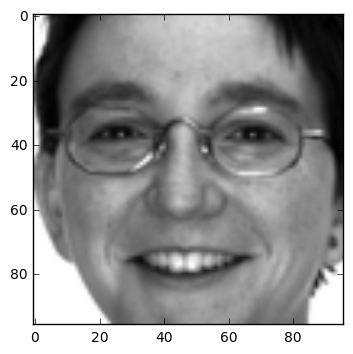

In [5]:
img = X[11].reshape(96, 96)
pyplot.imshow(img, cmap='gray')
pyplot.show()

Split the initial training dataset into training, validation and testing datasets.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5)

## Parameters

In [7]:
# Predefined parameters
image_size = 96
num_keypoints = 30
batch_size = 36
num_epochs = 401
learning_rate = 0.01
momentum = 0.9
model_path = "/tmp/single_layer_model.ckpt"

# Calculated parameters
num_steps_in_epoch = int((y_train.shape[0] + batch_size) / batch_size)
num_steps = num_steps_in_epoch * num_epochs

## Routines

Performs a single fully connected layer pass, e.g. returns `input * weights + bias`:

In [8]:
def fully_connected(input, size):
    weights = tf.get_variable( 'weights', 
        shape = [input.get_shape()[1], size],
        initializer = tf.contrib.layers.xavier_initializer()
      )
    biases = tf.get_variable( 'biases',
        shape = [size],
        initializer=tf.constant_initializer(0.0)
      )
    return tf.matmul(input, weights) + biases

Performs entire model pass, e.g. returns model prediction for given input with current model (single hidden fully connected layer):

In [14]:
def model_pass(input):
    with tf.variable_scope('hidden'):
        hidden = fully_connected(input, size = 100)
    relu_hidden = tf.nn.relu(hidden)
    with tf.variable_scope('out'):
        prediction = fully_connected(relu_hidden, size = num_keypoints)
    return prediction

Calculates a rough estimate of the Kaggle leaderboard score based on model predictions.

In [15]:
def calc_score(predictions, labels):
    return np.sqrt(np.mean(np.square(predictions - labels))) * 48.0

Calculates loss based on model predictions.

In [16]:
def calc_loss(predictions, labels):
    return np.mean(np.square(predictions - labels))

Calculates time since `start` and formats as a string.

In [17]:
def get_time_hhmmss(start):
    end = time.time()
    m, s = divmod(end - start, 60)
    h, m = divmod(m, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    return time_str

## Training

In [18]:
graph = tf.Graph()

with graph.as_default():
# Input data. For the training data, we use a placeholder that will be fed at run time with a training minibatch.
    tf_x_batch = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
    tf_y_batch = tf.placeholder(tf.float32, shape = (batch_size, num_keypoints))

    tf_x_valid = tf.constant(x_val)
    tf_x_test = tf.constant(x_test)
    tf_x_train = tf.constant(x_train)

    global_step = tf.Variable(0)  # count the number of steps taken.

# Training computation.
    with tf.variable_scope("single_hidden_layer_model"):
        pred = model_pass(tf_x_batch)
    
    loss = tf.reduce_mean(tf.square(pred - tf_y_batch))  
    
# Optimizer.
    optimizer = tf.train.MomentumOptimizer(
        learning_rate = learning_rate, 
        momentum = momentum, 
        use_nesterov = True
    ).minimize(
        loss, 
        global_step = global_step
    )

# Predictions for the training, validation, and test data. 
    with tf.variable_scope("single_hidden_layer_model", reuse = True):
        p_train = model_pass(tf_x_train)  
        p_valid = model_pass(tf_x_valid)  
        p_test = model_pass(tf_x_test)

In [19]:
start = time.time()

with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    saver = tf.train.Saver()
    train_loss = np.ndarray(num_epochs)
    valid_loss = np.ndarray(num_epochs)
    for step in range(num_steps):
        epoch = int((step + 1) / num_steps_in_epoch)
        # Pick an offset within the training data.
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = x_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        _, l, predictions = session.run(
            [optimizer, loss, pred], 
            feed_dict = {
                tf_x_batch : batch_data, 
                tf_y_batch : batch_labels
            }
        )

        global_step = step
        if (step % num_steps_in_epoch == 0):
            # Start of the new epoch
            train_loss[epoch] = calc_loss(p_train.eval(), y_train)
            valid_loss[epoch] = calc_loss(p_valid.eval(), y_val)
            if (epoch % 100 == 0):
                print("--------- EPOCH %4d/%d ---------" % (epoch, num_epochs))
                print("  Minibatch loss: %.8f" % (l))
                print("      Train loss: %.8f" % (train_loss[epoch]))
                print(" Validation loss: %.8f" % (valid_loss[epoch]))
                print("            Time: " + get_time_hhmmss(start))
    print("===================================")
    print(" Test score: %.3f" % calc_score(p_test.eval(), y_test))  
    print(" Total time: " + get_time_hhmmss(start))
    
    # Save model weights for future use.
    save_path = saver.save(session, model_path)
    print("Model file: " + save_path)

--------- EPOCH    0/401 ---------
  Minibatch loss: 0.84164971
      Train loss: 1.47529399
 Validation loss: 1.53788924
            Time: 00:00:00
--------- EPOCH  100/401 ---------
  Minibatch loss: 0.00228695
      Train loss: 0.00316501
 Validation loss: 0.00393120
            Time: 00:00:26
--------- EPOCH  200/401 ---------
  Minibatch loss: 0.00222288
      Train loss: 0.00227519
 Validation loss: 0.00316591
            Time: 00:00:51
--------- EPOCH  300/401 ---------
  Minibatch loss: 0.00198400
      Train loss: 0.00200677
 Validation loss: 0.00302347
            Time: 00:01:16
--------- EPOCH  400/401 ---------
  Minibatch loss: 0.00183343
      Train loss: 0.00191136
 Validation loss: 0.00302064
            Time: 00:01:43
 Test score: 2.746
 Total time: 00:01:43
Model file: /tmp/single_layer_model.ckpt


## Evaluation

Let's plot training and validation loss curves.

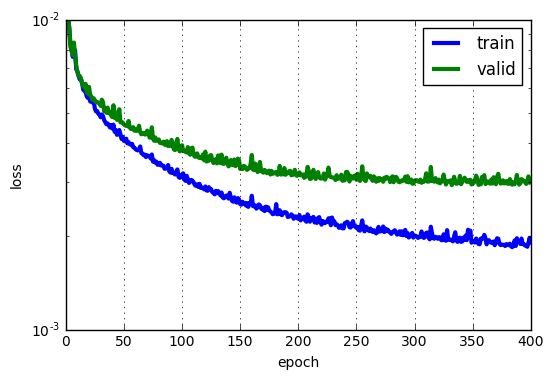

In [20]:
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(0.001, 0.01)
pyplot.xlim(0, 400)
pyplot.yscale("log")
pyplot.show()

Now, let's take a look at the data and predictions. 

Load training data, restore saved model parameters and get predictions:

In [21]:
X, _ = load(test = True)

with graph.as_default():
    tf_x = tf.constant(X)

    with tf.variable_scope("single_hidden_layer_model", reuse = True):
        p_y = model_pass(tf_x)  
        
with tf.Session(graph = graph) as session:
    tf.initialize_all_variables().run()
    load_path = saver.restore(session, model_path)
    predictions = p_y.eval()

ImageId    1783
Image      1783
dtype: int64


Display some of the dataset images and our model's predictions:

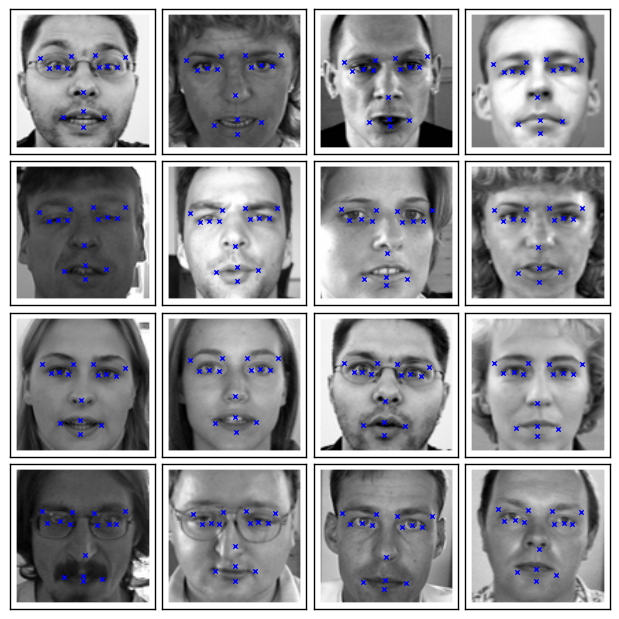

In [22]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], predictions[i], ax)

pyplot.show()